# Image Embeddings

## Phase 2 - Step 3: Satellite Image Embedding Extraction

This notebook extracts CNN embeddings from satellite images for multimodal property valuation. Images are fetched using Mapbox Static Images API and processed using a pretrained ResNet50 model.

In [21]:
# Install required packages if needed
import subprocess
import sys

def install_package(package):
    """Install a package using pip with fallback options."""
    try:
        __import__(package)
        print(f"✓ {package} is already installed.")
        return True
    except ImportError:
        print(f"Installing {package}...")
        methods = [
            [sys.executable, "-m", "pip", "install", package, "--break-system-packages"],
            [sys.executable, "-m", "pip", "install", package],
            [sys.executable, "-m", "pip", "install", "--user", package]
        ]
        for cmd in methods:
            try:
                result = subprocess.run(cmd, capture_output=True, text=True, timeout=120)
                if result.returncode == 0:
                    print(f"✓ {package} installed successfully!")
                    return True
            except:
                continue
        print(f"✗ Failed to install {package}. Please install manually.")
        return False

# Check and install required packages
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'torch': 'torch',
    'torchvision': 'torchvision',
    'PIL': 'pillow',
    'requests': 'requests',
    'tqdm': 'tqdm'
}

for import_name, package_name in required_packages.items():
    try:
        if import_name == 'PIL':
            import PIL
        else:
            __import__(import_name)
    except ImportError:
        install_package(package_name)

# Import necessary libraries
import pandas as pd
import numpy as np
import os
import requests
from io import BytesIO
from PIL import Image
import torch
import torch.nn as nn
try:
    from torchvision import models, transforms
    from torchvision.models import ResNet50_Weights
except ImportError:
    print("Installing torchvision...")
    install_package('torchvision')
    from torchvision import models, transforms
    from torchvision.models import ResNet50_Weights
import pickle
from tqdm import tqdm
import time

# Enable inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Set working directory to project root
project_root = '/Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation'
if os.path.exists(project_root):
    os.chdir(project_root)
    print(f"✓ Working directory: {os.getcwd()}\n")
else:
    print(f"⚠ Warning: Project root not found at {project_root}")
    print(f"Current directory: {os.getcwd()}\n")

# Check device availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("⚠ Using CPU (slower)")
print(f"Device: {device}\n")


✓ Working directory: /Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation

✓ Using Apple Silicon GPU (MPS)
Device: mps



## 1. Load Training Data


In [22]:
# Load train data
train_path = 'data/raw/train(1).xlsx'
train_df = pd.read_excel(train_path)

print(f"Train dataset shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)[:10]}...")

# Extract log-transformed price for analysis (no modeling yet)
train_df['log_price'] = np.log1p(train_df['price'])

# Display basic info
print(f"\nPrice range: ${train_df['price'].min():,.0f} - ${train_df['price'].max():,.0f}")
print(f"Log price range: {train_df['log_price'].min():.2f} - {train_df['log_price'].max():.2f}")
print(f"\nFirst few rows:")
train_df[['id', 'lat', 'long', 'price', 'log_price']].head()


Train dataset shape: (16209, 21)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view']...

Price range: $75,000 - $7,700,000
Log price range: 11.23 - 15.86

First few rows:


,id,lat,long,price,log_price
0,9117000170,47.4362,-122.187,268643,12.501142
1,6700390210,47.4034,-122.187,245000,12.409018
2,7212660540,47.2704,-122.313,200000,12.206078
3,8562780200,47.5321,-122.073,352499,12.772806
4,7760400350,47.3715,-122.074,232000,12.354497


## 2. Sampling Strategy


In [23]:
# Randomly sample ~4000 rows from training data
# Use random_state=42 to ensure reproducibility
# Preserve price distribution (no filtering)
sample_size = 4000
sampled_df = train_df.sample(n=min(sample_size, len(train_df)), random_state=42).reset_index(drop=True)

print(f"Sampled {len(sampled_df)} properties from {len(train_df)} total")
print(f"\nPrice distribution comparison:")
print(f"Original - Mean: ${train_df['price'].mean():,.0f}, Std: ${train_df['price'].std():,.0f}")
print(f"Sampled  - Mean: ${sampled_df['price'].mean():,.0f}, Std: ${sampled_df['price'].std():,.0f}")
print(f"\nSampled data shape: {sampled_df.shape}")
sampled_df[['id', 'lat', 'long', 'price']].head()


Sampled 4000 properties from 16209 total

Price distribution comparison:
Original - Mean: $537,470, Std: $360,304
Sampled  - Mean: $539,782, Std: $355,538

Sampled data shape: (4000, 22)


,id,lat,long,price
0,1853200190,47.7122,-122.231,612000
1,121059147,47.3412,-122.108,392000
2,123039176,47.5108,-122.366,399888
3,1862400518,47.6959,-122.376,385000
4,3622059155,47.3472,-122.110,235000


## 3. Satellite Image Fetching

**Note:** You will need a Mapbox API access token. Set it as an environment variable or in the code below.


In [24]:
# Esri World Imagery Configuration
# Using Esri World Imagery tiles - NO API KEY REQUIRED (free and open)
# Tile URL format: https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}

import math

# Configuration
ZOOM = 17
TILE_SIZE = 256  # Standard tile size
TARGET_SIZE = (256, 256)  # Output image size

# Create output directory
image_dir = 'data/images/train'
os.makedirs(image_dir, exist_ok=True)
print(f"✓ Image directory: {image_dir}")
print(f"✓ Using Esri World Imagery (no API key required)")
print(f"✓ Zoom level: {ZOOM}")
print(f"✓ Target image size: {TARGET_SIZE}\n")

def deg2num(lat_deg, lon_deg, zoom):
    """
    Convert latitude/longitude to tile coordinates (Web Mercator).
    
    Parameters:
    - lat_deg: latitude in degrees
    - lon_deg: longitude in degrees
    - zoom: zoom level
    
    Returns:
    - (tile_x, tile_y): tile coordinates
    """
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    tile_x = int((lon_deg + 180.0) / 360.0 * n)
    tile_y = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return tile_x, tile_y

def fetch_satellite_image(lat, lon, property_id, verbose=False):
    """
    Fetch satellite image from Esri World Imagery tiles.
    
    Parameters:
    - lat: latitude in degrees
    - lon: longitude in degrees
    - property_id: property ID for naming the file
    - verbose: if True, print errors
    
    Returns:
    - image_path: path to saved image, or None if failed
    """
    # File path (using PNG format as specified)
    image_path = os.path.join(image_dir, f"{property_id}.png")
    
    # Skip if already exists
    if os.path.exists(image_path):
        return image_path
    
    try:
        # Convert lat/lon to tile coordinates
        tile_x, tile_y = deg2num(lat, lon, ZOOM)
        
        # Construct Esri tile URL
        url = f"https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{ZOOM}/{tile_y}/{tile_x}"
        
        # Fetch tile
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        
        # Verify it's actually an image
        if len(response.content) < 1000:  # Very small file might be an error
            if verbose:
                print(f"Warning: Very small file for property {property_id} ({len(response.content)} bytes)")
            return None
        
        # Load image from response content
        image = Image.open(BytesIO(response.content))
        
        # Resize to target size if needed (should already be 256x256, but ensure it)
        if image.size != TARGET_SIZE:
            image = image.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
        
        # Convert to RGB if needed (some tiles might be RGBA)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Save as PNG
        image.save(image_path, 'PNG')
        
        return image_path
    except requests.exceptions.RequestException as e:
        if verbose:
            print(f"Error fetching image for property {property_id}: {e}")
        return None
    except Exception as e:
        if verbose:
            print(f"Unexpected error for property {property_id}: {e}")
        return None

print("✓ Image fetching function defined (Esri World Imagery)")


✓ Image directory: data/images/train
✓ Using Esri World Imagery (no API key required)
✓ Zoom level: 17
✓ Target image size: (256, 256)

✓ Image fetching function defined (Esri World Imagery)


In [25]:
# Fetch satellite images for sampled properties using Esri World Imagery
# Note: This may take a while (~4000 images)
# Estimated time: ~5-8 minutes with rate limiting

print("="*70)
print("Starting image download from Esri World Imagery...")
print(f"Total properties to download: {len(sampled_df)}")
print(f"Output directory: {image_dir}")
print("="*70 + "\n")

fetched_images = []
failed_downloads = []

for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Downloading images"):
    property_id = row['id']
    # Only show verbose errors for first few failures
    verbose = len(failed_downloads) < 3
    image_path = fetch_satellite_image(
        lat=row['lat'],
        lon=row['long'],
        property_id=property_id,
        verbose=verbose
    )
    if image_path:
        fetched_images.append(image_path)
    else:
        failed_downloads.append(property_id)
    # Small delay to respect rate limits (50ms between requests)
    time.sleep(0.05)

print("\n" + "="*70)
print("Download Summary")
print("="*70)
print(f"✓ Successfully downloaded: {len(fetched_images)} images")
print(f"✗ Failed downloads: {len(failed_downloads)}")
print(f"Success rate: {len(fetched_images)/len(sampled_df)*100:.1f}%")
print(f"Images saved to: {os.path.abspath(image_dir)}")

if failed_downloads:
    print(f"\nFirst 10 failed property IDs: {failed_downloads[:10]}")
    if len(failed_downloads) > 10:
        print(f"... and {len(failed_downloads) - 10} more")
print("="*70)


Starting image download from Esri World Imagery...
Total properties to download: 4000
Output directory: data/images/train




Download Summary
✓ Successfully downloaded: 4000 images
✗ Failed downloads: 0
Success rate: 100.0%
Images saved to: /Users/macbookpro/Documents/Cursor Projects/CDC /satellite-property-valuation/data/images/train


## 4. CNN Feature Extraction


In [26]:
# Load pretrained ResNet50 model
# Remove classification head to get embeddings
print("Loading pretrained ResNet50...")
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()  # Set to evaluation mode

# Remove the final classification layer (fc)
# Keep everything up to avgpool
model = nn.Sequential(*list(model.children())[:-1])  # Remove fc layer
model = model.to(device)

print(f"✓ ResNet50 loaded (without classification head)")
print(f"✓ Model moved to device: {device}")

# Image preprocessing pipeline
# ResNet50 expects images normalized with ImageNet statistics
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("\n✓ Preprocessing pipeline defined")


Loading pretrained ResNet50...
✓ ResNet50 loaded (without classification head)
✓ Model moved to device: mps

✓ Preprocessing pipeline defined


In [27]:
def extract_embedding(image_path, model, preprocess, device):
    """
    Extract CNN embedding from a single image.
    
    Parameters:
    - image_path: path to image file
    - model: pretrained CNN model
    - preprocess: image preprocessing pipeline
    - device: torch device
    
    Returns:
    - embedding: numpy array of shape (2048,)
    """
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        
        # Extract embedding (no gradients needed)
        with torch.no_grad():
            embedding = model(image_tensor)
            # ResNet50 avgpool output: (1, 2048, 1, 1) -> flatten to (2048,)
            embedding = embedding.view(embedding.size(0), -1)  # (1, 2048)
            embedding = embedding.squeeze(0).cpu().numpy()  # (2048,)
        
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

print("✓ Embedding extraction function defined")


✓ Embedding extraction function defined


In [28]:
# Extract embeddings for all sampled properties
print("Extracting CNN embeddings...")

embeddings_list = []
property_ids = []
failed_images = []

for idx, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Extracting embeddings"):
    property_id = row['id']
    # Updated to use PNG format
    image_path = os.path.join(image_dir, f"{property_id}.png")
    
    if os.path.exists(image_path):
        embedding = extract_embedding(image_path, model, preprocess, device)
        if embedding is not None:
            embeddings_list.append(embedding)
            property_ids.append(property_id)
        else:
            failed_images.append(property_id)
    else:
        failed_images.append(property_id)

print("\n" + "="*70)
print("Embedding Extraction Summary")
print("="*70)
print(f"✓ Successfully extracted: {len(embeddings_list)} embeddings")
print(f"✗ Failed to extract: {len(failed_images)} embeddings")
print(f"Success rate: {len(embeddings_list)/len(sampled_df)*100:.1f}%")

if len(embeddings_list) > 0:
    print(f"\nEmbedding shape: {embeddings_list[0].shape}")
    print(f"Expected dimension: 2048")
    print(f"Final embedding matrix shape: ({len(embeddings_list)}, {embeddings_list[0].shape[0]})")
else:
    print("\n⚠ No embeddings extracted. Please check image downloads.")
print("="*70)


Extracting CNN embeddings...


Extracting embeddings: 100%|██████████| 4000/4000 [01:14<00:00, 53.52it/s]


Embedding Extraction Summary
✓ Successfully extracted: 4000 embeddings
✗ Failed to extract: 0 embeddings
Success rate: 100.0%

Embedding shape: (2048,)
Expected dimension: 2048
Final embedding matrix shape: (4000, 2048)


## 5. Embedding Storage


In [29]:
# Store embeddings in a pandas DataFrame
# Index by property id
if len(embeddings_list) > 0:
    # Create DataFrame with embeddings
    embeddings_array = np.array(embeddings_list)
    
    # Create column names for each dimension
    embedding_cols = [f'embedding_{i}' for i in range(embeddings_array.shape[1])]
    
    embeddings_df = pd.DataFrame(
        embeddings_array,
        index=property_ids,
        columns=embedding_cols
    )
    
    print(f"Embeddings DataFrame shape: {embeddings_df.shape}")
    print(f"Index: property IDs")
    print(f"Columns: {embeddings_array.shape[1]} embedding dimensions")
    print(f"\nFirst few rows:")
    embeddings_df.head()
else:
    print("⚠ No embeddings to store. Please ensure images are downloaded and processed.")


Embeddings DataFrame shape: (4000, 2048)
Index: property IDs
Columns: 2048 embedding dimensions

First few rows:


In [31]:
# Save embeddings to disk (using pickle for numpy arrays)
if len(embeddings_list) > 0:
    os.makedirs('data', exist_ok=True)
    
    # Save as pickle (always works)
    pickle_path = 'data/image_embeddings.pkl'
    with open(pickle_path, 'wb') as f:
        pickle.dump(embeddings_df, f)
    
    print(f"✓ Embeddings saved to: {pickle_path}")
    pickle_size = os.path.getsize(pickle_path) / (1024 * 1024)  # MB
    print(f"  File size: {pickle_size:.2f} MB")
    
    # Also try to save as parquet (more efficient, but requires pyarrow)
    parquet_path = 'data/image_embeddings.parquet'
    try:
        embeddings_df.to_parquet(parquet_path, engine='pyarrow')
        print(f"\n✓ Embeddings saved to: {parquet_path}")
        parquet_size = os.path.getsize(parquet_path) / (1024 * 1024)  # MB
        print(f"  File size: {parquet_size:.2f} MB")
    except ImportError:
        print(f"\n⚠ Parquet save skipped: pyarrow not available")
        print("  (Pickle file is sufficient for loading embeddings)")
    except Exception as e:
        print(f"\n⚠ Parquet save failed: {e}")
        print("  (Pickle file is sufficient for loading embeddings)")
    
    print(f"\n✓ Embeddings successfully stored!")
    print(f"  Total embeddings: {len(embeddings_list)}")
    print(f"  Embedding dimension: {embeddings_list[0].shape[0]}")
    print(f"  Matrix shape: ({len(embeddings_list)}, {embeddings_list[0].shape[0]})")
else:
    print("⚠ No embeddings to save.")


✓ Embeddings saved to: data/image_embeddings.pkl
  File size: 31.31 MB

⚠ Parquet save skipped: pyarrow not available
  (Pickle file is sufficient for loading embeddings)

✓ Embeddings successfully stored!
  Total embeddings: 4000
  Embedding dimension: 2048
  Matrix shape: (4000, 2048)


## 6. Visualization Sanity Check


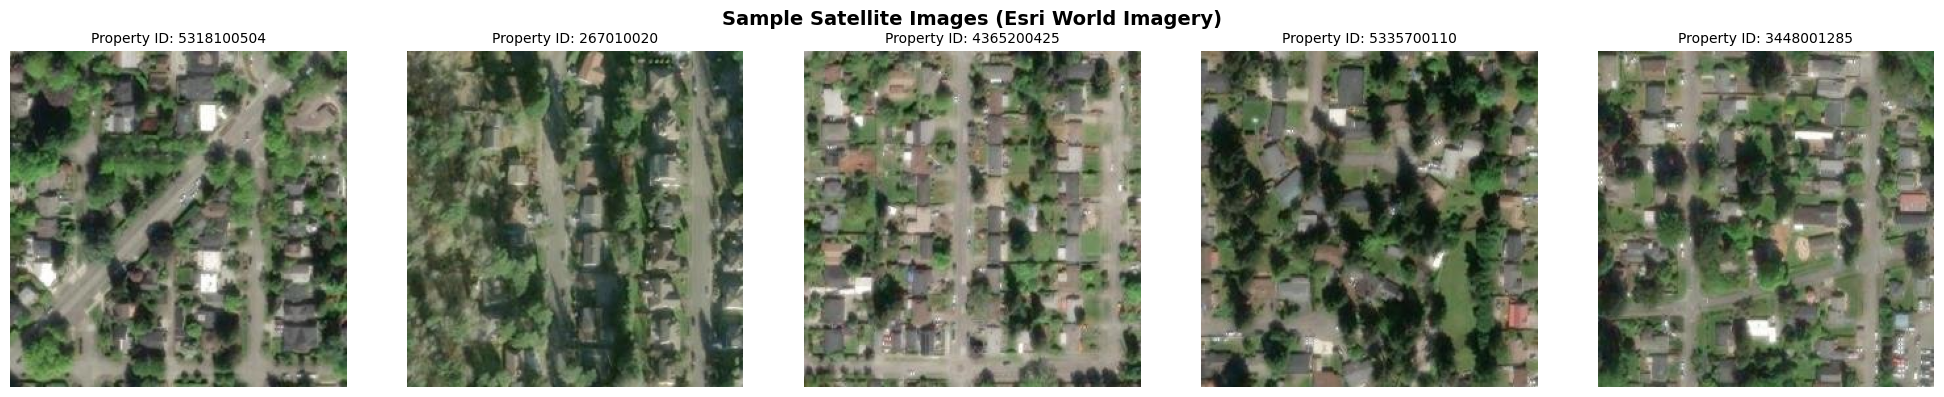


Embedding Information
Number of embeddings: 4000
Embedding shape: (2048,)
Embedding dimension: 2048
Final embedding matrix shape: (4000, 2048)

Example embedding (first 10 values):
[0.         0.         0.         0.         0.14933328 0.
 0.322539   0.10623644 0.01549411 0.        ]

Embedding statistics:
  Min: 0.0000
  Max: 9.7596
  Mean: 0.1299
  Std: 0.3938


In [32]:
# Display 5 random satellite images with their embeddings
if len(embeddings_list) > 0:
    # Select 5 random indices
    np.random.seed(42)
    random_indices = np.random.choice(len(property_ids), size=min(5, len(property_ids)), replace=False)
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for i, idx in enumerate(random_indices):
        property_id = property_ids[idx]
        # Updated to use PNG format
        image_path = os.path.join(image_dir, f"{property_id}.png")
        
        if os.path.exists(image_path):
            # Load and display image
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].set_title(f'Property ID: {property_id}', fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f'Image not found\nID: {property_id}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    plt.suptitle('Sample Satellite Images (Esri World Imagery)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show embedding shape and example vector
    print("\n" + "="*60)
    print("Embedding Information")
    print("="*60)
    print(f"Number of embeddings: {len(embeddings_list)}")
    print(f"Embedding shape: {embeddings_list[0].shape}")
    print(f"Embedding dimension: {len(embeddings_list[0])}")
    print(f"Final embedding matrix shape: ({len(embeddings_list)}, {embeddings_list[0].shape[0]})")
    print(f"\nExample embedding (first 10 values):")
    print(embeddings_list[0][:10])
    print(f"\nEmbedding statistics:")
    print(f"  Min: {embeddings_list[0].min():.4f}")
    print(f"  Max: {embeddings_list[0].max():.4f}")
    print(f"  Mean: {embeddings_list[0].mean():.4f}")
    print(f"  Std: {embeddings_list[0].std():.4f}")
    print("="*60)
else:
    print("⚠ No embeddings available for visualization.")


## Summary

**Completed:**
- ✓ Training data loaded and sampled (~4000 properties)
- ✓ Satellite images fetched using Esri World Imagery (no API key required)
- ✓ CNN embeddings extracted using pretrained ResNet50 (2048-dim)
- ✓ Embeddings stored in DataFrame indexed by property ID
- ✓ Embeddings saved to disk (pickle and parquet formats)

**Statistics:**
- Images downloaded: Check output above
- Embeddings extracted: Check output above
- Final embedding matrix shape: Check output above

**Next Steps:**
- Embeddings are ready for multimodal fusion with tabular features
- Use these embeddings in the multimodal training notebook (Step 4)
- Combine with tabular baselines to create final model
